# Klasifikácia bankových prevodov

## Obsah 
1. Príprava a načítanie dát
2. Vytvorené štruktúry
3. Idei pre klasifikáciu platieb<br>
    3.1. Grafová štruktúra<br>
    3.2. Použité riešenie<br>
    3.3. Klasifikácia ďalších kategórii<br>
4. Rozhodovanie na základe sumy a periodicity platieb<br>
    4.1. Idea<br>
    4.2. Implementácia<br>
    4.3. Nevýhody<br>
5. Filtrácia platieb na základe periodicity<br>
    5.1. Idea<br>
    5.1.1 Hľadanie termínov mzdy<br>
    5.1.2 Selekcia na základe výšky platby<br>
    5.2. Implementácia<br>
6. Trendy v dátach - 2 výšky platieb <br>
7. Klasterizácia<br>
    7.1. Navrhovaný algoritmus<br>
    7.1.1 Inicializácia centier<br>
    7.1.2 Výpočet chyby<br>
    7.2. Problémy riešenia<br>
    7.3 Implementácia<br>
    7.4.Vyhodnotenie klasterizácie<br>
8. Grafy<br>
    8.1. Príjem z jedného účtu v porovnaní s pravdepodobnosťou, že sa jedná o mzdu.<br>
    8.2. Výška platby vs. pravdepodobnosť, že na účet prichádza mzda<br>
    8.3 Percentuálne rozdelenie výšky platieb<br>
    8.4. Pravdepodobnosť, že platba je mzdou vs. výška platby<br>
9. Záver

Pozn: odporúčame spúšťať ukážky kódu v poradí v akom sú v notebook-u, sú na sebe závislé. 
Program v notebook-u a súboroch na gite sa môže líšiť.
    


### 1. Príprava a načítanie dát

Dáta pozostávajú z účtu odosielateľa platby, príjemcu, dátumu a sumy.
Dáta sme načítavali z txt súboru. Pôvodne sme chceli využiť Panda DataFrame, no jeho využitie neprinášalo žiadne výhody. Načítavanie do numpy array sa ukázalo ako príliš pomalé kvôli použitiu vstack operácie pre želaný formát dát. Preto sme sa nakoniec rozhodli pre použitie základných python štruktúr, ktoré sa ukázali aj ako najrýchlejší spôsob načítania. Zvažovali sme použitie databázy, no pre danú veľkosť dát bol postačujúci python.


### 2. Vytvorené štruktúry

V prvej verzii sme vytvorili slovník s kľúčom ako kombinácia odosielateľa a príjmateľa platby,
obsahujúci pole objektov triedy Payments. Táto trieda obsahuje odoslanú sumu a dátum odoslania. 
Neskôr sme zistili, že táto štruktúra nie je vyhovujúca, resp. práca s ňou nie je efektívna, preto sme vytvorili triedu Connections. Jej objekty sú v slovníku s rovnakými kľúčami ako Payments, no pre zistenie celkovej sumy nie je potrebné iterovať cez pole objektov.



In [30]:
import numpy as np
import datetime
"""
load dataset
"""

class Loader:
	
	
	class Payment:
		def __init__(self, date, amount):
			self.date = date
			self.amount = amount
			self.is_salary = 0	#percentage
			self.k_means_error = 0
			
	class Connection:
		def __init__(self):
			self.payments = []
			self.is_salary = 0
			self.one_cl_err = 0
			self.two_cl_err = 0
			self.err_rate = 0
			self.cluster_err_perc = 0
			self.cluster_perc = 0
			self.cluster_dst = 0	#for low and heigh cluster center
			self.cluster_dst_perc = 0
			self.date_amount = []
			self.amounts = []
			self.salaries = []		# for payments that we think are salaries
			self.salary_perc = 0	# percentage that sequence is salary according to payment_process.py
		def add_payment(self, paym):
			self.payments.append(paym)
			
	def __init__(self, fname):
		counter = 0
		self.data = []
		self.payments = dict()
		self.payments_list = dict()
		self.keyset = set()
		self.amounts = list()
		with open(fname) as f:
			for line in f:
				if counter % 100000 == 0:
					print("data proccessed " + str(counter))   # just to see python did not get stuck
				counter += 1
				l = list(line.strip().split('\t'))
				timest =  [int(x) for x in l[0].split('-')]	#split datestring on '-'
				l[0] = datetime.datetime(timest[0], timest[1], timest[2])	# needs 3 integers as argument to make datetime object
				l[2] = int(l[2])	#sum as integer
				self.data.append(l)	#tried dataframe, numpy array, simple list seems to be the fastest
				key_payments = l[1] + '#' + l[3]
				if key_payments in self.keyset:		#much faster than asking for keys()
					self.payments[key_payments].append(self.Payment(l[0], l[2]))
					
					self.payments_list[key_payments].add_payment(self.Payment(l[0], l[2]))		#with object Connection
				else:
					self.payments[key_payments] = []
					self.payments[key_payments].append(self.Payment(l[0], l[2]))
					
					self.payments_list[key_payments] = self.Connection()
					self.payments_list[key_payments].add_payment(self.Payment(l[0], l[2]))
					
				self.payments_list[key_payments].date_amount.append([l[0], l[2]])
				self.payments_list[key_payments].amounts.append(l[2])	#for graph easy access to amounts
				self.keyset.add(key_payments)
				
				self.amounts.append(l[2])
		
		
l = Loader('data_for_applicants.txt')


data proccessed 0
data proccessed 100000
data proccessed 200000
data proccessed 300000
data proccessed 400000


### 3. Idei pre klasifikáciu platieb

#### 3.1 Grafová štruktúra
Prvotný nápad bol vytvoriť grafovú štruktúru kde by účty boli vrcholy a platby hrany. Tento prístup by vyžadoval prehľadávanie grafovými algoritmami. Pri skúmaní use-case-ov pre fyzické osoby sme nenarazili na masívne výhody tohto prístupu pre identifikáciu miezd. Výhodami by bola možna práca s tranzitívnosťou údajov, teda možná identifikácia reťazcov platieb. Táto grafová štruktúra by bola vyvinutá ako ďalší krok po terajšom riešení.

#### 3.2 Použité riešenie

Pre fyzické osoby sme mali predpoklad, že mzda bude prichádzať z jedného účtu, teda aj bez reťazcov platieb neprídeme o veľa informácie. Implementovali sme slovník, ktorý obsahuje objekt triedy udržiavajúcej detaily o platbách medzi účtami, v priebehu výpočtu nové dáta a nakoniec aj výsledok vo forme pravdepodobnosti. Pre vyššiu presnosť riešeniu sme sa snažili vyhýbať pevným ohraničeniam, teda výsledky uvádzame v pravdepodobnosti. Pre určenie mzdy sme ale použili niekoľko logických ohraničení ako výšku platby a jej periodicitu.

#### 3.3 Klasifikácia ďalších kategórii

Jednoduche kategórie, ako kategorizáciu podľa výšky platieb sme neimplementovali, pretože sme to považovali za triviálne. Platby ako predaj tovaru medzi fyzickými osobami by sme vyhľadávali opačným postupom ako mzdy, teda platby ktoré nemajú žiadnu periodicitu a variancia ich sumy je vysoká. Ak ma fyzická osoba druhý príjem z 2. zamestnania, mohla by ho odhaliť ďalej navrhnutá a implementovaná klasterizácia.





### 4. Rozhodovanie na základe sumy a periodicity platieb - prvý prístup

#### 4.1. Idea
   Aby bola platba klasifkovaná ako výplata, zvažujeme v tomto prístupe periodicitu platby a varianciu vo výške platieb. Pre každý prvok v slovníku payments, teda dvojicu účtov, kde z účtu A odchádzajú platby na účet B, vypočítame rozdiel v dátume platieb.Čím je priemer týchto rozdielov vzdialenejší od počtu dní v mesiaci, tým väčšia pravdepodobnosť, že dané platby neboli výplatami. Variancu vo vyplácaných sumách získame ako štandardnú odchýlku deleno priemer platieb. Čím väčšia variancia, tým nižšia pravdepodobnosť, že ide o výplaty.
Ak sa chyba v časoch platieb a suma platieb pohybuje v stanovených medziach, chyby zaznamenáme. V ďalšej metóde následne pre dvojice účtov kde máme zaznamenú chybu, prevedieme chybu na pravdepodobnosť, že sa jedná o výplaty

#### 4.2. Nevýhody
   Hlavným problémom tohto prístupu, je vyhodnotenie buď všetkých platieb medzi 2 účtami ako mzdy, alebo kvôli niekoľkým platbam nevyhovujúcej sumy, alebo v inom dátume vyhodnotenie, že pre žiadnu platbu sa nejedná o mzdu. Medzi dvomi účtami sa môžu medzi mzdami vyskytnúť rôzne transakcie, toto tento prístup neberie do úvahy.
Tento problém sme odstránili v nasledujúcom prístupe.

#### 4.3. Implementácia
    

In [31]:
from __future__ import division
import numpy as np
import datetime
import warnings

class Payment_process:
	
	
	def __init__(self, loaded):
		self.payments = loaded.payments
		self.keyset = loaded.keyset
		self.connections = loaded.payments_list
		warnings.filterwarnings("ignore")
		
	def sort_payments(self):
		for key, value in self.payments.items():
			self.payments[key].sort(key=lambda x: x.date)
			
	def sort_connections(self, data):
		return sorted(data, key = lambda data:data[0])	#sort by date
			
	def normalize_data(self, data):
		data -= np.mean(data, keepdims = True)
		data = [int(i) for i in data]
		data /= np.std(data, keepdims = True)
		return data
	
	def scale_data(self, data):
		return (data - np.min(data))/np.ptp(data)

	def scale_data_from_dict(self, data, divide=None, scale=None):
		min_d = float(np.min([i for i in data.values()]))
		ptp_d = np.ptp(list(data.values()))	# range of values
		for k,v in data.items():
			data_k_fl = float(data[k])
			data[k] = (data_k_fl - min_d)/ptp_d
			if divide:
				data[k] = data_k_fl/divide
			if scale:
				data[k] = data_k_fl*scale
		return data
	

	def process(self):
		counter = 0
		all_err_dates = dict()
		all_err_income = dict()
		all_err = dict()
		for key, p in self.payments.items():
			if len(p) > 4:	# at leat N salaries
				delta_dates = []
				income_list = [p[0].amount,]
				for pay_ind in range(0, len(p) - 1):
					delta = p[pay_ind + 1].date - p[pay_ind].date
					delta_dates.append(delta.days)
					income_list.append(p[pay_ind + 1].amount)
				dates_norm = self.normalize_data(delta_dates)
				err_income = np.std(income_list)/np.mean(income_list)
				err_dates = abs(np.mean(delta_dates) - 30.411)	#avg num off days in month
				if err_dates < 5 and 7700 < np.median(income_list) < 115000:		# max error of 5 days, otherwise not a salary, salary sum must be reasonable
					all_err_dates[key] = err_dates
					all_err_income[key] = err_income
					all_err[key] = (err_income*5 + err_dates/4)		#weighting of errors
				else:
					# not considered income
					pass
		return all_err_dates, all_err_income, all_err
	
	def process_errors(self, all_err_dates, all_err_income, all_err):
		all_err_sc = self.scale_data_from_dict(all_err)
		for k,v in all_err_sc.items():
			prob = (1 - v*4)*100
			if 0 <prob <100:
				print('probability of being a salary : ' + str(prob) + '%')
				print('having these payments : ')
				for i in self.payments[k]:
					print(i.amount, end = ', ')
				print('\n')
				self.connections[k].is_salary = prob
        
pp = Payment_process(l)
pp.sort_payments()
dates_errs, income_errs, all_err = pp.process()
pp.process_errors(dates_errs, income_errs, all_err)

probability of being a salary : 98.4685400015%
having these payments : 
14993, 14995, 14993, 14998, 14994, 14994, 

probability of being a salary : 94.7147750225%
having these payments : 
35288, 33390, 33539, 33295, 32540, 

probability of being a salary : 86.6909284785%
having these payments : 
23816, 21910, 21901, 25356, 21907, 21907, 

probability of being a salary : 90.3684959976%
having these payments : 
9156, 8251, 9153, 9152, 9150, 9150, 

probability of being a salary : 90.8871970734%
having these payments : 
12264, 11438, 12177, 11949, 11133, 11985, 

probability of being a salary : 87.9115761612%
having these payments : 
14313, 14139, 14489, 14045, 15393, 14416, 

probability of being a salary : 97.8611921779%
having these payments : 
8177, 8125, 8178, 8178, 8148, 8101, 

probability of being a salary : 46.1207266194%
having these payments : 
24560, 25379, 51740, 48267, 41098, 29530, 

probability of being a salary : 96.0691486704%
having these payments : 
9225, 9221, 9221, 9

9839, 9981, 9927, 9894, 9938, 9775, 

probability of being a salary : 92.5563726587%
having these payments : 
15933, 17438, 16485, 16703, 15904, 15866, 

probability of being a salary : 96.2838375949%
having these payments : 
11335, 11387, 11388, 11389, 11389, 11388, 

probability of being a salary : 30.0986930959%
having these payments : 
8035, 8033, 8036, 8039, 7995, 8005, 71, 

probability of being a salary : 88.6483154444%
having these payments : 
15481, 15415, 15595, 16140, 17529, 15447, 

probability of being a salary : 95.7207704087%
having these payments : 
14580, 14415, 14685, 14557, 14456, 14588, 

probability of being a salary : 76.1506986335%
having these payments : 
11604, 11833, 12217, 14339, 12814, 9169, 

probability of being a salary : 95.2128362942%
having these payments : 
34913, 34913, 34842, 35145, 34564, 35596, 

probability of being a salary : 90.3545803469%
having these payments : 
12989, 14771, 14665, 14482, 14988, 14780, 

probability of being a salary : 74.84

12057, 12057, 11989, 12197, 12117, 12195, 

probability of being a salary : 97.7805937564%
having these payments : 
8890, 8895, 8861, 8886, 8894, 8792, 

probability of being a salary : 97.8070599354%
having these payments : 
8544, 8544, 8543, 8513, 8452, 8544, 

probability of being a salary : 87.2332877428%
having these payments : 
8671, 9981, 10169, 8978, 10112, 10243, 

probability of being a salary : 94.8103385206%
having these payments : 
10783, 10789, 10789, 10789, 10782, 10781, 

probability of being a salary : 91.9037103781%
having these payments : 
9308, 10181, 10287, 9458, 10077, 10149, 

probability of being a salary : 82.2641476717%
having these payments : 
8009, 8640, 9120, 7095, 7168, 

probability of being a salary : 36.5081355986%
having these payments : 
19431, 10901, 10710, 10204, 10265, 7187, 

probability of being a salary : 97.3926070945%
having these payments : 
12788, 12779, 12758, 12647, 12640, 12639, 

probability of being a salary : 46.8336880224%
having thes

12403, 12188, 12408, 12691, 12403, 12407, 

probability of being a salary : 76.2429165262%
having these payments : 
17246, 17161, 17170, 24072, 20172, 18881, 

probability of being a salary : 87.2775707855%
having these payments : 
12878, 13007, 12878, 12801, 14376, 

probability of being a salary : 96.6858394149%
having these payments : 
15258, 15281, 15367, 14942, 15460, 15300, 

probability of being a salary : 18.2975255523%
having these payments : 
28623, 50734, 63523, 68796, 10044, 50971, 

probability of being a salary : 97.0772654992%
having these payments : 
22356, 22384, 22457, 22410, 22887, 22384, 

probability of being a salary : 70.7687974377%
having these payments : 
15048, 15094, 15879, 22261, 15752, 16003, 

probability of being a salary : 72.2198013274%
having these payments : 
20354, 16132, 15488, 21662, 15648, 15810, 

probability of being a salary : 90.544532767%
having these payments : 
12335, 12462, 13614, 12334, 12337, 12592, 

probability of being a salary : 80.7

17746, 18254, 19398, 17772, 20423, 16304, 

probability of being a salary : 98.3469605035%
having these payments : 
24782, 24781, 24781, 24726, 24780, 24779, 

probability of being a salary : 98.0811073399%
having these payments : 
10420, 10458, 10458, 10451, 10453, 10455, 

probability of being a salary : 69.5327312985%
having these payments : 
13328, 10431, 10431, 15387, 11779, 15108, 

probability of being a salary : 79.0344479583%
having these payments : 
44561, 37219, 34436, 30833, 37172, 38581, 

probability of being a salary : 97.6447730688%
having these payments : 
8464, 8461, 8461, 8376, 8463, 8463, 

probability of being a salary : 68.1312836644%
having these payments : 
24945, 21682, 20734, 18554, 18211, 13740, 

probability of being a salary : 98.3171788588%
having these payments : 
9641, 9644, 9644, 9642, 9646, 9618, 

probability of being a salary : 67.0244565211%
having these payments : 
11311, 12391, 11538, 17642, 11213, 11423, 

probability of being a salary : 73.71637

18505, 18917, 16850, 17213, 16410, 14172, 

probability of being a salary : 46.596458387%
having these payments : 
16367, 16650, 16682, 23529, 27207, 33810, 

probability of being a salary : 56.1194667531%
having these payments : 
21777, 38137, 24566, 35818, 24610, 22081, 

probability of being a salary : 86.8150052705%
having these payments : 
19819, 21878, 22661, 23171, 23218, 19661, 

probability of being a salary : 22.1853154115%
having these payments : 
74128, 64429, 64430, 68927, 7976, 

probability of being a salary : 80.0053797194%
having these payments : 
25172, 25818, 19575, 20462, 22226, 20523, 

probability of being a salary : 74.678798991%
having these payments : 
16483, 16651, 21281, 23017, 19496, 17370, 

probability of being a salary : 91.4944254213%
having these payments : 
19882, 21381, 20950, 20980, 21690, 20134, 

probability of being a salary : 68.8162514162%
having these payments : 
17930, 13525, 13036, 19222, 13590, 13528, 

probability of being a salary : 65.990

25651, 26389, 27125, 25319, 26086, 25398, 

probability of being a salary : 98.645092747%
having these payments : 
76564, 77469, 76567, 76570, 75401, 76831, 

probability of being a salary : 94.4425983209%
having these payments : 
8743, 8743, 8743, 8728, 8657, 8740, 

probability of being a salary : 54.938036214%
having these payments : 
8943, 8643, 8843, 8662, 3817, 

probability of being a salary : 76.6325274271%
having these payments : 
16547, 17118, 19056, 20255, 23481, 19830, 

probability of being a salary : 95.9826616002%
having these payments : 
31235, 31334, 31328, 31535, 31432, 31528, 

probability of being a salary : 21.6065907972%
having these payments : 
1037, 8310, 13891, 13086, 14778, 13639, 

probability of being a salary : 96.7353741151%
having these payments : 
18362, 18371, 18366, 18363, 18370, 18372, 

probability of being a salary : 97.7243113527%
having these payments : 
8018, 8021, 8024, 7925, 8026, 8006, 

probability of being a salary : 16.4208051943%
having th

25769, 25877, 29465, 23551, 25023, 

probability of being a salary : 72.6369197464%
having these payments : 
13311, 12869, 17112, 11114, 11943, 11813, 

probability of being a salary : 66.711007153%
having these payments : 
17113, 13172, 13817, 12430, 10344, 11323, 

probability of being a salary : 98.4242078722%
having these payments : 
9004, 9001, 8997, 9004, 9001, 8995, 

probability of being a salary : 79.1411014498%
having these payments : 
11359, 11185, 10319, 10657, 12817, 13702, 

probability of being a salary : 94.8181066825%
having these payments : 
11822, 11830, 11822, 11824, 11830, 11825, 

probability of being a salary : 98.0234278448%
having these payments : 
9050, 9119, 9114, 9115, 9115, 9117, 

probability of being a salary : 42.4374921234%
having these payments : 
20330, 41871, 20902, 20592, 20547, 20976, 

probability of being a salary : 63.6147613859%
having these payments : 
27194, 21443, 20162, 34547, 23339, 20978, 

probability of being a salary : 88.6963516643%
h


probability of being a salary : 71.5227824069%
having these payments : 
13766, 13671, 13947, 13794, 18866, 

probability of being a salary : 77.8083367719%
having these payments : 
26431, 24958, 31033, 26331, 26529, 26494, 

probability of being a salary : 77.0845336298%
having these payments : 
17712, 17688, 19608, 24808, 18317, 19700, 

probability of being a salary : 98.1518798322%
having these payments : 
9205, 9202, 9158, 9207, 9207, 9209, 

probability of being a salary : 83.2504547018%
having these payments : 
10210, 10105, 11063, 10240, 10763, 11095, 

probability of being a salary : 81.0427178718%
having these payments : 
43060, 42830, 56879, 49811, 46456, 45598, 

probability of being a salary : 89.2968484584%
having these payments : 
12722, 12601, 12724, 12725, 12719, 12720, 

probability of being a salary : 79.0677010404%
having these payments : 
20057, 19577, 18230, 25023, 18801, 18936, 

probability of being a salary : 98.3809681947%
having these payments : 
12941, 12944

13827, 13828, 13827, 13830, 13738, 13836, 

probability of being a salary : 93.3056195416%
having these payments : 
28324, 28323, 28324, 28319, 28319, 28308, 

probability of being a salary : 83.566295746%
having these payments : 
14290, 18805, 15532, 14443, 15162, 15739, 

probability of being a salary : 96.7437068667%
having these payments : 
9594, 9593, 9595, 9598, 9595, 9596, 

probability of being a salary : 80.6212208733%
having these payments : 
10421, 10461, 10470, 13178, 10357, 10443, 

probability of being a salary : 98.189445527%
having these payments : 
9565, 9567, 9570, 9561, 9561, 9521, 

probability of being a salary : 41.3553026151%
having these payments : 
21849, 21392, 22999, 18598, 23190, 6199, 

probability of being a salary : 74.3451531134%
having these payments : 
18219, 17849, 16824, 14776, 22147, 20563, 

probability of being a salary : 55.6237272163%
having these payments : 
12668, 5661, 14268, 11918, 11791, 12989, 

probability of being a salary : 80.422873380


probability of being a salary : 51.915230084%
having these payments : 
10793, 18434, 27609, 18116, 19901, 17808, 

probability of being a salary : 91.2865038581%
having these payments : 
13208, 14025, 15174, 13605, 14003, 

probability of being a salary : 91.2912586481%
having these payments : 
13720, 13803, 13801, 13799, 13799, 14980, 

probability of being a salary : 93.0155192865%
having these payments : 
21991, 21982, 22444, 23803, 23193, 22029, 

probability of being a salary : 82.8227005242%
having these payments : 
22946, 23888, 28334, 24753, 21035, 24948, 

probability of being a salary : 95.9300935919%
having these payments : 
21914, 22152, 22626, 21967, 22177, 21628, 

probability of being a salary : 87.7296554587%
having these payments : 
20056, 19238, 19223, 21260, 20484, 18010, 

probability of being a salary : 36.5477309302%
having these payments : 
8499, 8502, 10558, 11970, 11994, 11999, 12001, 

probability of being a salary : 98.1474030776%
having these payments : 
10

13607, 14243, 13420, 18039, 13655, 12439, 

probability of being a salary : 85.9221609222%
having these payments : 
13664, 13802, 14349, 14933, 14335, 16429, 

probability of being a salary : 91.6033103079%
having these payments : 
10161, 9088, 9125, 9121, 9345, 9232, 

probability of being a salary : 89.1984458139%
having these payments : 
15494, 15523, 15521, 15492, 15422, 15637, 

probability of being a salary : 95.9392956782%
having these payments : 
8463, 8460, 8407, 8467, 8533, 8416, 

probability of being a salary : 84.2879278019%
having these payments : 
7649, 8978, 9689, 9600, 9721, 9734, 

probability of being a salary : 63.7486390157%
having these payments : 
8461, 8459, 8467, 8460, 12469, 12450, 

probability of being a salary : 98.4410873537%
having these payments : 
9107, 9111, 9108, 9106, 9113, 9107, 

probability of being a salary : 77.2076275638%
having these payments : 
28188, 21708, 21550, 22063, 24138, 21498, 

probability of being a salary : 98.4515727713%
having t

10916, 9686, 11279, 10352, 11674, 12647, 

probability of being a salary : 35.4103321789%
having these payments : 
24785, 8333, 24786, 13816, 15123, 

probability of being a salary : 72.8061858945%
having these payments : 
27944, 26471, 26490, 27133, 31496, 37999, 

probability of being a salary : 98.0177609162%
having these payments : 
11585, 11589, 11586, 11502, 11589, 11586, 

probability of being a salary : 98.1170173551%
having these payments : 
9880, 9881, 9877, 9821, 9877, 9875, 

probability of being a salary : 98.4821976791%
having these payments : 
54947, 54947, 54942, 54943, 54945, 54944, 

probability of being a salary : 91.6894061648%
having these payments : 
10711, 11056, 11481, 10502, 11244, 10895, 

probability of being a salary : 97.8185634415%
having these payments : 
27082, 27075, 27075, 27215, 27312, 27311, 

probability of being a salary : 98.434912711%
having these payments : 
11703, 11702, 11703, 11697, 11696, 11694, 

probability of being a salary : 91.747999461

20556, 20720, 20701, 20540, 21132, 20585, 

probability of being a salary : 95.554527688%
having these payments : 
12573, 12891, 12248, 12505, 12490, 12272, 

probability of being a salary : 71.8041146263%
having these payments : 
10724, 10954, 10894, 11270, 10896, 10827, 

probability of being a salary : 98.2554473875%
having these payments : 
8218, 8213, 8216, 8214, 8187, 8220, 

probability of being a salary : 90.3614361141%
having these payments : 
14569, 14878, 13605, 14731, 13646, 14808, 

probability of being a salary : 89.2483591326%
having these payments : 
9941, 9980, 9877, 9923, 9976, 9983, 

probability of being a salary : 97.728523773%
having these payments : 
28162, 28169, 28162, 28414, 28412, 28418, 

probability of being a salary : 81.7458231212%
having these payments : 
14013, 13186, 13884, 16586, 14777, 12756, 

probability of being a salary : 96.5272028985%
having these payments : 
17104, 17109, 17042, 17109, 17103, 17110, 

probability of being a salary : 96.5588165

14960, 14964, 14962, 14964, 14922, 14964, 

probability of being a salary : 61.5944769767%
having these payments : 
21195, 14455, 15365, 23199, 14703, 14720, 

probability of being a salary : 17.6452600585%
having these payments : 
16670, 16570, 16592, 42544, 17094, 16387, 

probability of being a salary : 96.1958069723%
having these payments : 
11162, 11158, 11162, 11160, 11093, 11160, 

probability of being a salary : 74.3601955363%
having these payments : 
17853, 18151, 18123, 17864, 19901, 24934, 

probability of being a salary : 74.4827434121%
having these payments : 
11406, 12485, 17201, 11800, 12545, 12465, 

probability of being a salary : 74.3560322281%
having these payments : 
21244, 21488, 14600, 24011, 21161, 21430, 

probability of being a salary : 33.507598866%
having these payments : 
3016, 19332, 20682, 18838, 21966, 22596, 

probability of being a salary : 94.4056049493%
having these payments : 
15100, 14877, 15362, 14873, 15368, 15275, 

probability of being a salary 

9625, 9691, 9706, 9712, 9705, 9712, 

probability of being a salary : 95.2825497913%
having these payments : 
20937, 20935, 20935, 20928, 19893, 20932, 

probability of being a salary : 98.426864455%
having these payments : 
9111, 9103, 9104, 9107, 9111, 9110, 

probability of being a salary : 98.2663138902%
having these payments : 
11665, 11669, 11628, 11665, 11670, 11648, 

probability of being a salary : 77.9854787646%
having these payments : 
33334, 28828, 28591, 30618, 30361, 39691, 

probability of being a salary : 66.3673491319%
having these payments : 
24262, 24333, 23852, 35025, 22028, 22026, 

probability of being a salary : 94.5616064288%
having these payments : 
8637, 8614, 8573, 8637, 8636, 

probability of being a salary : 93.4588972067%
having these payments : 
9203, 9202, 9680, 9197, 9198, 9197, 

probability of being a salary : 67.2001964587%
having these payments : 
28492, 19945, 26260, 28471, 19111, 18891, 

probability of being a salary : 72.1060759871%
having these


probability of being a salary : 95.0262470402%
having these payments : 
13017, 12804, 13059, 13092, 13188, 13093, 

probability of being a salary : 80.7117223631%
having these payments : 
12117, 12704, 12233, 15018, 12422, 

probability of being a salary : 97.9331079441%
having these payments : 
9249, 9245, 9244, 9220, 9246, 9165, 

probability of being a salary : 91.5165633107%
having these payments : 
11454, 11251, 10329, 10661, 10273, 10746, 

probability of being a salary : 98.0426291945%
having these payments : 
32626, 32617, 32618, 32803, 32809, 32741, 

probability of being a salary : 96.4003905562%
having these payments : 
12234, 12230, 12232, 12229, 12229, 12160, 

probability of being a salary : 88.9738114261%
having these payments : 
20868, 19084, 18405, 18672, 20356, 19749, 

probability of being a salary : 97.8573463736%
having these payments : 
9925, 9917, 9919, 9924, 9922, 9824, 

probability of being a salary : 94.61753109%
having these payments : 
11071, 11048, 11076,

11521, 10896, 11156, 11562, 10503, 10499, 

probability of being a salary : 94.8023501723%
having these payments : 
14481, 14481, 14470, 14478, 14486, 14486, 

probability of being a salary : 73.6590693543%
having these payments : 
17208, 17390, 17556, 24421, 17019, 17377, 

probability of being a salary : 90.8697925922%
having these payments : 
11129, 11841, 11847, 11474, 12784, 11458, 

probability of being a salary : 98.2630418369%
having these payments : 
8053, 8060, 8059, 8053, 8057, 8029, 

probability of being a salary : 84.3995390772%
having these payments : 
18403, 19040, 22726, 18412, 20182, 18130, 

probability of being a salary : 94.4690030199%
having these payments : 
10560, 10562, 10563, 10562, 10566, 10466, 

probability of being a salary : 90.9530684848%
having these payments : 
19082, 19558, 19076, 19359, 18221, 20411, 

probability of being a salary : 73.1157404609%
having these payments : 
23581, 22927, 22987, 33040, 23539, 23010, 

probability of being a salary : 58

probability of being a salary : 98.2804959043%
having these payments : 
19542, 19540, 19541, 19542, 19536, 19542, 

probability of being a salary : 98.0951845387%
having these payments : 
9746, 9748, 9741, 9704, 9736, 9690, 

probability of being a salary : 95.8954452509%
having these payments : 
12858, 12861, 12861, 12959, 12967, 12964, 

probability of being a salary : 25.4755410024%
having these payments : 
80410, 77161, 77161, 79902, 11236, 

probability of being a salary : 85.7446639761%
having these payments : 
13026, 11510, 10967, 11658, 11697, 12037, 

probability of being a salary : 92.1068644035%
having these payments : 
17261, 18918, 18090, 18089, 17997, 18373, 

probability of being a salary : 70.3564007919%
having these payments : 
11867, 18055, 21260, 17050, 19239, 17570, 

probability of being a salary : 73.735994313%
having these payments : 
13863, 13435, 19217, 17270, 18585, 20358, 

probability of being a salary : 69.1458308631%
having these payments : 
25700, 18252, 

8272, 8338, 8253, 8337, 8268, 8307, 

probability of being a salary : 81.2422135982%
having these payments : 
25227, 25150, 25232, 24827, 29973, 30504, 

probability of being a salary : 81.7576292667%
having these payments : 
10853, 10524, 10558, 13417, 10426, 10423, 

probability of being a salary : 90.5632537562%
having these payments : 
14175, 15080, 14357, 14830, 15797, 

probability of being a salary : 95.0844721901%
having these payments : 
15060, 14593, 14902, 14650, 15159, 14304, 

probability of being a salary : 91.0873908516%
having these payments : 
9984, 10320, 10598, 9615, 10472, 10282, 

probability of being a salary : 84.2692102878%
having these payments : 
16821, 14368, 14965, 13244, 15240, 14452, 

probability of being a salary : 89.7461692025%
having these payments : 
16018, 18370, 18255, 18333, 18453, 

probability of being a salary : 85.7311881451%
having these payments : 
18223, 15116, 16477, 18132, 16591, 16317, 

probability of being a salary : 93.9568281362%
hav

26715, 29101, 31474, 36821, 27527, 28614, 

probability of being a salary : 30.8441496226%
having these payments : 
15734, 15235, 15735, 15231, 14892, 1570, 

probability of being a salary : 98.1080395969%
having these payments : 
10855, 10849, 10852, 10850, 10787, 10850, 

probability of being a salary : 59.7310802005%
having these payments : 
13786, 13812, 10253, 9704, 9701, 

probability of being a salary : 99.1370391375%
having these payments : 
13817, 13813, 13798, 13817, 13773, 

probability of being a salary : 67.0914566682%
having these payments : 
35715, 22964, 23795, 29876, 26116, 22917, 

probability of being a salary : 40.1810745859%
having these payments : 
17212, 13739, 4212, 17257, 17241, 17418, 

probability of being a salary : 98.4721421691%
having these payments : 
17207, 17207, 17207, 17203, 17206, 17208, 

probability of being a salary : 96.1520326036%
having these payments : 
10204, 10265, 10426, 10138, 10041, 10415, 

probability of being a salary : 60.5435412039%

having these payments : 
14004, 13242, 14056, 13219, 13463, 14603, 

probability of being a salary : 94.4525853064%
having these payments : 
10239, 10314, 10269, 10281, 10217, 10315, 

probability of being a salary : 71.7864266267%
having these payments : 
10574, 10618, 11646, 15233, 11279, 11445, 

probability of being a salary : 87.5852104468%
having these payments : 
11372, 12802, 13026, 12536, 12819, 12751, 

probability of being a salary : 82.8095184174%
having these payments : 
10941, 10243, 10246, 11718, 11202, 12485, 

probability of being a salary : 89.91542754%
having these payments : 
9148, 9150, 9155, 10113, 9103, 9054, 

probability of being a salary : 81.5392022789%
having these payments : 
11667, 9937, 10174, 8689, 9618, 8930, 

probability of being a salary : 9.96443159411%
having these payments : 
11524, 11732, 14338, 9075, 4151, 9199, 12793, 

probability of being a salary : 98.4396963406%
having these payments : 
11476, 11474, 11480, 11475, 11475, 11483, 

probabilit


probability of being a salary : 79.6938868769%
having these payments : 
21111, 17795, 22403, 23770, 18547, 21040, 

probability of being a salary : 72.6595748875%
having these payments : 
14556, 14762, 10631, 17161, 17113, 16692, 

probability of being a salary : 98.457095864%
having these payments : 
13814, 13819, 13812, 13812, 13813, 13812, 

probability of being a salary : 94.8091043808%
having these payments : 
8503, 8471, 8499, 8508, 8504, 8500, 

probability of being a salary : 51.6394850575%
having these payments : 
29328, 31722, 51984, 27345, 30965, 24825, 

probability of being a salary : 97.571765962%
having these payments : 
9711, 9679, 9712, 9676, 9590, 9689, 

probability of being a salary : 76.7135508581%
having these payments : 
21338, 22223, 22565, 29388, 23118, 21783, 

probability of being a salary : 78.0864386631%
having these payments : 
19551, 16507, 22026, 18790, 16437, 16994, 

probability of being a salary : 90.0885571177%
having these payments : 
21134, 21747,

having these payments : 
55678, 41312, 38085, 28871, 44218, 61498, 

probability of being a salary : 95.2203634325%
having these payments : 
13141, 13146, 13178, 12932, 13326, 13227, 

probability of being a salary : 82.1466732255%
having these payments : 
14114, 13874, 14870, 14428, 14014, 15791, 

probability of being a salary : 94.6120598283%
having these payments : 
26684, 27579, 27577, 27267, 27579, 26989, 

probability of being a salary : 86.5345511389%
having these payments : 
14980, 17205, 16916, 18097, 16158, 16227, 

probability of being a salary : 95.0190030877%
having these payments : 
9386, 9388, 9389, 9385, 9385, 9383, 

probability of being a salary : 85.2318830397%
having these payments : 
10797, 11325, 11271, 11170, 11329, 11354, 

probability of being a salary : 74.6396800232%
having these payments : 
9965, 9971, 9967, 9884, 6697, 9972, 

probability of being a salary : 88.4579994593%
having these payments : 
17180, 17421, 17393, 17329, 18886, 15989, 

probability of 

probability of being a salary : 97.7917451456%
having these payments : 
8324, 8328, 8325, 8324, 8326, 8235, 

probability of being a salary : 41.9637404869%
having these payments : 
3803, 11013, 11038, 10470, 11929, 11317, 

probability of being a salary : 80.7298031807%
having these payments : 
25367, 25568, 25452, 33126, 25529, 26926, 

probability of being a salary : 96.5637833537%
having these payments : 
16446, 16451, 16452, 16450, 16397, 16452, 

probability of being a salary : 97.9603993578%
having these payments : 
25104, 25103, 24897, 25104, 25106, 25102, 

probability of being a salary : 71.0700088885%
having these payments : 
16047, 16265, 15889, 22934, 15634, 16447, 

probability of being a salary : 53.894676467%
having these payments : 
7304, 10785, 8351, 15760, 13904, 11748, 

probability of being a salary : 77.4231072335%
having these payments : 
11750, 12663, 16103, 10628, 12888, 12420, 

probability of being a salary : 97.9702591586%
having these payments : 
12836, 128

18559, 19361, 19358, 18560, 20162, 18564, 

probability of being a salary : 97.8758932771%
having these payments : 
8262, 8270, 8332, 8287, 8329, 8330, 

probability of being a salary : 97.2247265548%
having these payments : 
12514, 12224, 12455, 12322, 12793, 12729, 

probability of being a salary : 15.2441768315%
having these payments : 
33274, 58039, 19023, 18538, 43197, 19355, 

probability of being a salary : 64.6875965226%
having these payments : 
25782, 16338, 16635, 18911, 18471, 16417, 

probability of being a salary : 82.516617525%
having these payments : 
15332, 17808, 17647, 16673, 18899, 19907, 

probability of being a salary : 98.2444317374%
having these payments : 
9676, 9709, 9711, 9715, 9716, 9711, 

probability of being a salary : 85.4999453383%
having these payments : 
34689, 33190, 33925, 36067, 40858, 33143, 

probability of being a salary : 95.0204306296%
having these payments : 
14218, 14215, 14212, 14219, 14211, 14214, 

probability of being a salary : 85.393318

37694, 38520, 38624, 38526, 38848, 38146, 

probability of being a salary : 97.6452729491%
having these payments : 
9823, 9913, 9801, 9793, 9874, 9906, 

probability of being a salary : 18.9662360556%
having these payments : 
16808, 14201, 15095, 15141, 6127, 15145, 13676, 

probability of being a salary : 95.0309209292%
having these payments : 
14490, 14491, 14496, 14492, 14493, 14490, 

probability of being a salary : 46.829440419%
having these payments : 
17642, 4833, 14326, 13842, 14459, 13829, 

probability of being a salary : 78.2479501252%
having these payments : 
19139, 20172, 19253, 25739, 19093, 19342, 

probability of being a salary : 51.5604300732%
having these payments : 
11232, 8520, 11057, 10333, 11591, 4623, 

probability of being a salary : 81.2683367197%
having these payments : 
12057, 11870, 12274, 12410, 14509, 15237, 

probability of being a salary : 95.7526556804%
having these payments : 
20756, 20747, 20756, 20958, 20951, 20955, 

probability of being a salary : 

16945, 18582, 18836, 17793, 21413, 17447, 

probability of being a salary : 87.6932592301%
having these payments : 
14366, 16318, 16318, 16864, 14339, 16022, 

probability of being a salary : 75.8281820586%
having these payments : 
11133, 11389, 11982, 7554, 12031, 11417, 

probability of being a salary : 58.791612822%
having these payments : 
11894, 13818, 14278, 14483, 12237, 11516, 

probability of being a salary : 77.4855544853%
having these payments : 
19976, 27944, 23538, 21373, 27180, 22552, 

probability of being a salary : 96.6791770987%
having these payments : 
29131, 29189, 29228, 28534, 28579, 28623, 

probability of being a salary : 90.4229947662%
having these payments : 
25787, 23720, 23718, 23187, 23632, 23209, 

probability of being a salary : 94.2730011476%
having these payments : 
31857, 31857, 33095, 32377, 32379, 31729, 

probability of being a salary : 98.0901312233%
having these payments : 
16951, 16944, 16950, 16953, 16946, 16894, 

probability of being a salary 

having these payments : 
8917, 8915, 11002, 8912, 8917, 8909, 

probability of being a salary : 98.0536519186%
having these payments : 
9119, 9122, 9122, 9126, 9062, 9128, 

probability of being a salary : 67.4942270683%
having these payments : 
20252, 18591, 11404, 16030, 19462, 18379, 

probability of being a salary : 86.4386842476%
having these payments : 
13974, 13771, 15626, 13974, 15414, 14407, 

probability of being a salary : 98.4497735605%
having these payments : 
14089, 14091, 14086, 14082, 14083, 14087, 

probability of being a salary : 96.4055857337%
having these payments : 
15899, 15825, 15827, 15894, 15899, 15899, 

probability of being a salary : 71.3403036422%
having these payments : 
28073, 39172, 44319, 40578, 46339, 43624, 

probability of being a salary : 91.1719083514%
having these payments : 
19674, 17579, 17681, 17831, 17477, 18103, 

probability of being a salary : 86.1221518231%
having these payments : 
12247, 12345, 12317, 12013, 14337, 12395, 

probability of

27061, 20105, 16200, 17668, 18164, 17950, 

probability of being a salary : 88.1896948264%
having these payments : 
23536, 20656, 20936, 22259, 20431, 21984, 

probability of being a salary : 94.9897283394%
having these payments : 
8465, 8473, 8469, 8472, 8465, 8466, 

probability of being a salary : 83.7185379339%
having these payments : 
15634, 14777, 17162, 13302, 15027, 14847, 

probability of being a salary : 97.3894254399%
having these payments : 
7874, 7961, 7965, 7955, 7864, 7948, 

probability of being a salary : 97.7467896464%
having these payments : 
9919, 9894, 9992, 9999, 9992, 9917, 

probability of being a salary : 78.9056074693%
having these payments : 
11890, 11682, 14269, 12266, 10968, 12209, 

probability of being a salary : 89.0572615956%
having these payments : 
15810, 15794, 14981, 14599, 14525, 14804, 

probability of being a salary : 97.0113468782%
having these payments : 
15979, 15977, 15971, 15974, 15689, 15682, 

probability of being a salary : 77.4101205996%

17416, 19410, 17950, 18584, 19043, 

probability of being a salary : 28.4175105878%
having these payments : 
1714, 11445, 11380, 11309, 11548, 

probability of being a salary : 94.1388627279%
having these payments : 
24108, 24105, 24110, 24103, 24992, 24787, 

probability of being a salary : 98.4701436891%
having these payments : 
32076, 32078, 32078, 32084, 32082, 32085, 

probability of being a salary : 86.6593300882%
having these payments : 
12384, 14154, 14621, 14648, 14832, 14549, 

probability of being a salary : 81.1711083157%
having these payments : 
16047, 15478, 18874, 15935, 14035, 15492, 

probability of being a salary : 98.2234037751%
having these payments : 
14922, 14859, 14917, 14896, 14920, 14923, 

probability of being a salary : 82.5426773302%
having these payments : 
7733, 7407, 7736, 8071, 9116, 9124, 

probability of being a salary : 95.9323240831%
having these payments : 
14203, 13810, 14270, 13811, 14270, 14270, 

probability of being a salary : 80.5721534579%
ha

12386, 13510, 13447, 13531, 14773, 13557, 

probability of being a salary : 90.7530891318%
having these payments : 
10603, 10634, 11460, 11486, 11948, 11684, 

probability of being a salary : 71.1195164825%
having these payments : 
20974, 21130, 21831, 21808, 24664, 30944, 

probability of being a salary : 89.1278983111%
having these payments : 
8661, 9942, 10648, 10335, 10262, 9911, 

probability of being a salary : 61.0578789217%
having these payments : 
9228, 9117, 12106, 9454, 5791, 

probability of being a salary : 92.0079830733%
having these payments : 
17649, 17289, 17534, 17402, 17202, 15725, 

probability of being a salary : 96.5554659677%
having these payments : 
14562, 14559, 14555, 14559, 14561, 14557, 

probability of being a salary : 98.3865607579%
having these payments : 
11057, 11076, 11073, 11069, 11073, 11076, 

probability of being a salary : 87.5100439672%
having these payments : 
10079, 10094, 10511, 10188, 10202, 10194, 

probability of being a salary : 97.8789000

13250, 13362, 13286, 13369, 13711, 13323, 

probability of being a salary : 92.1476826395%
having these payments : 
22232, 22750, 23449, 22020, 23202, 24495, 

probability of being a salary : 81.2824434263%
having these payments : 
12809, 12721, 13180, 15940, 14909, 12967, 

probability of being a salary : 95.6911181552%
having these payments : 
11375, 11373, 11371, 11495, 11486, 11494, 

probability of being a salary : 81.7182983387%
having these payments : 
15335, 16821, 16111, 16887, 20006, 16460, 

probability of being a salary : 68.9168982891%
having these payments : 
16720, 12069, 11684, 10955, 11442, 11077, 

probability of being a salary : 87.7201727759%
having these payments : 
11991, 13295, 13093, 12336, 13356, 13434, 

probability of being a salary : 98.3340459811%
having these payments : 
14637, 14634, 14639, 14664, 14664, 14660, 

probability of being a salary : 65.4536589804%
having these payments : 
17527, 18202, 18571, 28916, 19245, 19267, 

probability of being a salar

7709, 7708, 7669, 7725, 7723, 7720, 

probability of being a salary : 97.8316583803%
having these payments : 
27655, 27662, 27660, 27870, 27870, 27874, 

probability of being a salary : 94.8120533485%
having these payments : 
11261, 11258, 11250, 11259, 11258, 11260, 

probability of being a salary : 98.99373686%
having these payments : 
8329, 8289, 8317, 8328, 8293, 

probability of being a salary : 96.0885020738%
having these payments : 
9140, 9137, 9041, 9137, 9138, 9140, 

probability of being a salary : 94.7625319146%
having these payments : 
9730, 9731, 9730, 9732, 9687, 9734, 

probability of being a salary : 92.8913989647%
having these payments : 
9213, 9102, 8893, 9081, 9578, 9152, 

probability of being a salary : 76.8888063363%
having these payments : 
13897, 14693, 10397, 13595, 15030, 15849, 

probability of being a salary : 95.9470820202%
having these payments : 
7708, 7710, 7758, 7760, 7759, 7691, 

probability of being a salary : 77.8711424612%
having these payments : 


23885, 23982, 23982, 24210, 24210, 24214, 

probability of being a salary : 68.9202667634%
having these payments : 
8328, 8335, 6962, 11000, 6962, 

probability of being a salary : 93.611875979%
having these payments : 
50352, 54847, 51463, 51467, 51450, 51266, 

probability of being a salary : 97.3017317162%
having these payments : 
16562, 16522, 16635, 16542, 16492, 16835, 

probability of being a salary : 84.4753232754%
having these payments : 
20936, 16791, 22061, 21074, 20303, 20370, 

probability of being a salary : 72.0186168088%
having these payments : 
28581, 26234, 28263, 36652, 23463, 24466, 

probability of being a salary : 86.9045059623%
having these payments : 
10594, 10451, 11098, 11100, 10491, 10491, 

probability of being a salary : 91.1849850588%
having these payments : 
17997, 18314, 17807, 16888, 18763, 17620, 

probability of being a salary : 87.3846452925%
having these payments : 
8589, 8172, 8175, 8076, 9134, 8151, 

probability of being a salary : 62.5636085728%

26676, 19759, 22004, 20411, 18089, 16998, 

probability of being a salary : 84.6264607406%
having these payments : 
9944, 12224, 12311, 12076, 13105, 12074, 

probability of being a salary : 99.9816413711%
having these payments : 
15457, 15465, 15457, 15463, 15460, 15458, 

probability of being a salary : 94.5103443996%
having these payments : 
19270, 19594, 19990, 20037, 19718, 19853, 

probability of being a salary : 98.4439536663%
having these payments : 
18598, 18601, 18603, 18613, 18606, 18607, 

probability of being a salary : 87.8539371849%
having these payments : 
13813, 13798, 13737, 13811, 13815, 13788, 

probability of being a salary : 92.059366164%
having these payments : 
21809, 21293, 21258, 23292, 21228, 20920, 

probability of being a salary : 97.8816632529%
having these payments : 
9533, 9582, 9511, 9577, 9532, 9607, 

probability of being a salary : 96.7409056013%
having these payments : 
14120, 14117, 14121, 14121, 14120, 14114, 

probability of being a salary : 91.4

77185, 27107, 26585, 27354, 27014, 26525, 

probability of being a salary : 62.9453317259%
having these payments : 
20180, 35039, 29116, 34791, 24916, 24074, 

probability of being a salary : 82.6037254224%
having these payments : 
26946, 35716, 29208, 29251, 32074, 29093, 

probability of being a salary : 97.691313822%
having these payments : 
21954, 22015, 21954, 21956, 22223, 21919, 

probability of being a salary : 96.5015259171%
having these payments : 
20004, 20006, 19990, 19981, 20003, 20006, 

probability of being a salary : 94.3158324508%
having these payments : 
14533, 14627, 14586, 14625, 14629, 14458, 

probability of being a salary : 96.0646558581%
having these payments : 
12486, 12565, 12479, 12563, 12569, 12550, 

probability of being a salary : 98.4375335934%
having these payments : 
13814, 13806, 13814, 13811, 13816, 13819, 

probability of being a salary : 42.4323619322%
having these payments : 
20549, 40189, 20959, 18611, 20880, 22602, 

probability of being a salary

having these payments : 
25020, 22648, 22839, 25058, 22791, 22728, 

probability of being a salary : 89.0765820995%
having these payments : 
27247, 27514, 27551, 27541, 27257, 27322, 

probability of being a salary : 86.1190691253%
having these payments : 
18309, 18306, 18209, 18312, 18312, 18313, 

probability of being a salary : 97.746935042%
having these payments : 
7919, 7834, 7915, 7922, 7923, 7867, 

probability of being a salary : 75.5073303504%
having these payments : 
14289, 14240, 12862, 15565, 15082, 18863, 

probability of being a salary : 60.1022388923%
having these payments : 
14215, 22548, 25302, 14659, 17814, 16088, 

probability of being a salary : 98.3376819705%
having these payments : 
11591, 11617, 11617, 11620, 11620, 11616, 

probability of being a salary : 63.8343224793%
having these payments : 
30102, 20807, 22759, 31443, 20949, 18644, 

probability of being a salary : 68.3469415735%
having these payments : 
11204, 11206, 11202, 11210, 11207, 6831, 

probability

26869, 28834, 28781, 28837, 29458, 28794, 

probability of being a salary : 98.3945437417%
having these payments : 
11002, 10994, 11001, 10998, 10994, 10984, 

probability of being a salary : 87.9963917122%
having these payments : 
16411, 16342, 17279, 17761, 17562, 15276, 

probability of being a salary : 60.0730156244%
having these payments : 
16253, 16747, 17174, 27687, 18689, 16535, 

probability of being a salary : 98.2044246263%
having these payments : 
9484, 9494, 9497, 9493, 9452, 9495, 

probability of being a salary : 59.7383338152%
having these payments : 
5558, 11827, 12095, 10479, 12289, 12435, 

probability of being a salary : 86.7381154513%
having these payments : 
12632, 15142, 12791, 13509, 12814, 14363, 

probability of being a salary : 98.3522173332%
having these payments : 
11074, 11051, 11071, 11073, 11075, 11077, 

probability of being a salary : 82.809217337%
having these payments : 
39656, 39418, 51003, 42843, 46528, 44100, 

probability of being a salary : 80.6

31268, 31261, 31270, 31527, 31530, 31494, 

probability of being a salary : 96.925419228%
having these payments : 
19079, 19124, 19083, 19516, 19224, 19301, 

probability of being a salary : 67.8786142791%
having these payments : 
14642, 13235, 13454, 19822, 14870, 12916, 

probability of being a salary : 43.376149804%
having these payments : 
12477, 12608, 7985, 12552, 4468, 8652, 

probability of being a salary : 53.0708452019%
having these payments : 
62748, 77631, 72512, 53084, 44996, 55381, 

probability of being a salary : 38.465193313%
having these payments : 
45781, 21656, 21662, 21282, 22392, 21629, 

probability of being a salary : 81.482397378%
having these payments : 
17742, 17768, 22145, 17682, 17681, 17786, 

probability of being a salary : 84.6221706228%
having these payments : 
26163, 27633, 31683, 30096, 30396, 31958, 

probability of being a salary : 97.9990013226%
having these payments : 
9905, 9902, 9902, 9826, 9898, 9900, 

probability of being a salary : 93.675508


probability of being a salary : 60.8221781204%
having these payments : 
27535, 27594, 36523, 46705, 28543, 27809, 

probability of being a salary : 69.3821642808%
having these payments : 
14986, 14349, 16136, 13658, 11901, 9606, 

probability of being a salary : 13.9238246741%
having these payments : 
25505, 25561, 60271, 69655, 25713, 25933, 

probability of being a salary : 95.9720861971%
having these payments : 
12000, 12003, 12003, 12086, 12091, 12086, 

probability of being a salary : 95.8829004284%
having these payments : 
19650, 20211, 20209, 20398, 19730, 19664, 

probability of being a salary : 94.5549783907%
having these payments : 
9248, 9247, 9151, 9427, 9424, 9427, 

probability of being a salary : 84.4734981647%
having these payments : 
14065, 13914, 14353, 16520, 15295, 14301, 

probability of being a salary : 93.8155400847%
having these payments : 
15276, 15052, 15036, 14931, 15149, 15024, 

probability of being a salary : 86.1278989518%
having these payments : 
10145,

10410, 10418, 10411, 10414, 10418, 10415, 

probability of being a salary : 2.71903046457%
having these payments : 
9153, 9149, 1783, 9150, 9579, 9687, 9686, 

probability of being a salary : 94.8395512792%
having these payments : 
15181, 15181, 15184, 15186, 15187, 15186, 

probability of being a salary : 85.6807944402%
having these payments : 
11764, 13910, 14030, 13338, 13007, 12145, 

probability of being a salary : 75.3641737152%
having these payments : 
10960, 11386, 10952, 10964, 14800, 

probability of being a salary : 88.6554886291%
having these payments : 
15223, 15221, 17148, 15223, 15217, 15224, 

probability of being a salary : 90.6335453905%
having these payments : 
12190, 12302, 12566, 11665, 13434, 11907, 

probability of being a salary : 86.9931416204%
having these payments : 
11543, 14239, 12149, 12116, 12511, 12671, 

probability of being a salary : 71.0565442138%
having these payments : 
14091, 18742, 21100, 19551, 15008, 

probability of being a salary : 63.9651962

having these payments : 
9115, 9193, 9147, 9120, 9077, 9170, 

probability of being a salary : 36.575757343%
having these payments : 
11078, 17932, 11053, 16554, 13752, 4194, 

probability of being a salary : 79.2166076621%
having these payments : 
26361, 26202, 26656, 26096, 33634, 30760, 

probability of being a salary : 89.0957109413%
having these payments : 
9911, 9997, 9762, 9982, 11092, 10502, 

probability of being a salary : 75.5894965116%
having these payments : 
12422, 14419, 15449, 18253, 16228, 17393, 

probability of being a salary : 86.4122923396%
having these payments : 
20439, 19829, 20280, 19531, 17180, 17300, 

probability of being a salary : 94.0717226078%
having these payments : 
9007, 9137, 9072, 9011, 9110, 

probability of being a salary : 57.5345320735%
having these payments : 
26765, 38507, 26736, 26774, 23878, 17911, 

probability of being a salary : 61.8964916109%
having these payments : 
18514, 16320, 16322, 18202, 18174, 

probability of being a salary : 94

9033, 9033, 9032, 9033, 8950, 9037, 

probability of being a salary : 34.1696705949%
having these payments : 
25563, 11571, 15172, 10877, 11445, 11320, 

probability of being a salary : 41.9909945963%
having these payments : 
19645, 21133, 19672, 43664, 23094, 22815, 

probability of being a salary : 95.825073182%
having these payments : 
14025, 14770, 14361, 14773, 13975, 13977, 

probability of being a salary : 82.907412308%
having these payments : 
14952, 18037, 16210, 16698, 18516, 17644, 

probability of being a salary : 70.470713355%
having these payments : 
14976, 15308, 20088, 16144, 14538, 16117, 

probability of being a salary : 98.4420431112%
having these payments : 
13735, 13737, 13734, 13742, 13734, 13743, 

probability of being a salary : 46.7943022477%
having these payments : 
20199, 20225, 24455, 36587, 40127, 20946, 

probability of being a salary : 22.717152227%
having these payments : 
8797, 9570, 9459, 9037, 8215, 2142, 

probability of being a salary : 94.713865031

13939, 13465, 13554, 13552, 13753, 13893, 

probability of being a salary : 60.2172996748%
having these payments : 
9764, 8662, 8606, 8572, 7729, 4405, 

probability of being a salary : 77.2705811843%
having these payments : 
11825, 14482, 11434, 10357, 11791, 12014, 

probability of being a salary : 94.5542841639%
having these payments : 
11839, 11841, 11848, 11842, 11842, 11750, 

probability of being a salary : 87.6562566995%
having these payments : 
12863, 12012, 13574, 13549, 13177, 13606, 

probability of being a salary : 84.4180683539%
having these payments : 
17302, 17438, 17400, 16903, 15869, 15835, 

probability of being a salary : 96.2954403488%
having these payments : 
9338, 9282, 9356, 9352, 9349, 9354, 

probability of being a salary : 80.0649551613%
having these payments : 
29115, 26530, 25799, 25516, 32914, 25604, 

probability of being a salary : 94.8178679433%
having these payments : 
8747, 8712, 8743, 8742, 8747, 8738, 

probability of being a salary : 69.3991544552%

having these payments : 
16187, 17560, 17428, 16078, 16164, 16825, 

probability of being a salary : 83.002407811%
having these payments : 
16506, 15749, 15935, 18798, 14980, 14980, 

probability of being a salary : 73.9559272124%
having these payments : 
10248, 10255, 10249, 14123, 10250, 10197, 

probability of being a salary : 98.0032978002%
having these payments : 
13632, 13629, 13526, 13627, 13632, 13594, 

probability of being a salary : 91.1617823162%
having these payments : 
23632, 22658, 21539, 22951, 21677, 22120, 

probability of being a salary : 45.5255170873%
having these payments : 
13320, 13250, 13326, 25505, 13239, 13259, 

probability of being a salary : 96.4928511904%
having these payments : 
20037, 20036, 20036, 20030, 20008, 20038, 

probability of being a salary : 71.0203453077%
having these payments : 
11942, 11945, 11947, 11943, 17469, 11944, 

probability of being a salary : 96.7215167624%
having these payments : 
17127, 17344, 17203, 17081, 16473, 17534, 

prob

probability of being a salary : 98.4258162414%
having these payments : 
8333, 8336, 8329, 8327, 8334, 8332, 

probability of being a salary : 85.6132370375%
having these payments : 
12075, 11995, 11991, 12105, 12324, 11715, 

probability of being a salary : 97.8431325963%
having these payments : 
8610, 8532, 8603, 8552, 8614, 8609, 

probability of being a salary : 89.371244013%
having these payments : 
7405, 7769, 8433, 7963, 8604, 8470, 

probability of being a salary : 43.6674395776%
having these payments : 
7977, 9166, 9186, 16918, 16911, 16917, 

probability of being a salary : 20.9486190554%
having these payments : 
17032, 45773, 17821, 17445, 25562, 17459, 

probability of being a salary : 94.0924422094%
having these payments : 
7726, 7817, 7825, 7821, 7821, 7817, 

probability of being a salary : 92.5844164565%
having these payments : 
18010, 17158, 17845, 17241, 16404, 18139, 

probability of being a salary : 97.3410115714%
having these payments : 
7711, 7773, 7776, 7679, 7675

15000, 2784, 7887, 14808, 15906, 16422, 

probability of being a salary : 70.6094735928%
having these payments : 
11535, 11321, 12209, 17235, 12531, 11471, 

probability of being a salary : 73.0265630387%
having these payments : 
25767, 25360, 36602, 24238, 26672, 27702, 

probability of being a salary : 86.1966571337%
having these payments : 
12494, 12059, 12036, 12759, 12583, 12509, 

probability of being a salary : 98.1182150769%
having these payments : 
10489, 10549, 10547, 10547, 10551, 10554, 

probability of being a salary : 90.6574713703%
having these payments : 
9107, 9092, 9056, 9102, 9964, 9295, 

probability of being a salary : 78.9331454543%
having these payments : 
13458, 16325, 16771, 17194, 14534, 13224, 

probability of being a salary : 98.0921029602%
having these payments : 
13321, 13320, 13238, 13318, 13318, 13324, 

probability of being a salary : 96.7510233882%
having these payments : 
13815, 13817, 13814, 13815, 13815, 13819, 

probability of being a salary : 38.5

16399, 17080, 16077, 16626, 24826, 16155, 

probability of being a salary : 63.0764117023%
having these payments : 
28440, 29890, 27050, 46143, 38502, 29335, 

probability of being a salary : 57.4929954379%
having these payments : 
15304, 16747, 15398, 15688, 10380, 8381, 

probability of being a salary : 94.5863096921%
having these payments : 
13672, 13774, 13769, 13773, 13773, 13775, 

probability of being a salary : 98.3997450348%
having these payments : 
9496, 9500, 9487, 9502, 9494, 9493, 

probability of being a salary : 87.9255977564%
having these payments : 
21598, 21603, 21607, 21599, 21512, 21598, 

probability of being a salary : 80.9814994929%
having these payments : 
26200, 25081, 20313, 28814, 25075, 26278, 

probability of being a salary : 72.8806018868%
having these payments : 
22035, 16315, 16521, 16131, 16129, 14579, 

probability of being a salary : 20.5747549334%
having these payments : 
39471, 67790, 148924, 67747, 67116, 68137, 

probability of being a salary : 88

### 5. Filtrácia platieb na základe periodicity

Po uvedomení si nevýhod predošlého prístupu sme sa rozhodli navrhnúť nový. Jeho hlavným cieľom je odstrániť nevýhody prvého.

#### 5.1. Idea

Mzdy budú silne viazané na periodicitu cca 1 mesiaca, medzi nimi môžu nastať iné platby. Tie ale pravdepodobne nebudú nastávať s mesačnou periodicitou. Pôvodná idea bolo nájsť sekvencie opakujúcich sa platieb a ich periódu opakovania. Kvôli krátkosti času sme použili zjednodušené riešenie. 

5.1.1. Hľadanie termínov mzdy

Nájdeme priemer z dní v mesiaci v ktorých prichádzajú platby na účet, predpokladáme, že mzdy kvôli podobným dátumom budú mať najvyššiu váhu a priemer im bude blízky. Tento predpoklad sa nám potvrdil. Následné vypočítame odchýlku platieb od priemeru a štandardnú varianciu dátumov platieb.
Na základe týchto parametrov sa rozhodneme či platbu (nie celý sled platieb ako pri predošlom prístupe), zaradíme do ďalšieho vyhodnocovania. Čím menšia celková odchýlka od priemeru a menšia variancia, tým je väčšia pravdepodobnosť, že sa jedná o mzdu. Pre väčšiu selektívnosť v tejto fáze taktiež zohľadnujeme výšku platby, ktorá musí byť vo vopred stanovených hraniciach. Takisto variancia dátumov nesmie prekročiť stanovenú hranicu. Po prekročení tejto hranice variancie sú dátumy v slede platieb takmer náhodné a nie je v nich mesačná periodicita ani s vysokou toleranciou posunu mzdy o niekoľko dní.

5.1.2. Selekcia na základe výšky platby

Pre platby označené v bode 5.1.1. ako možné mzdy, sme postupovali ďalej. Ako vzorec pre výpočet, či sa jedná o mzdu, sme štandardnú odchýlku platieb vydelili jej priemerom. Tento údaj sme nasledne previedli na percentá, ktoré vyjadrujú istotu, že sa jedná o mzdu.

#### 5.2 Implementácia

In [32]:
class Payment_process:
	
	def __init__(self, loaded):
		self.payments = loaded.payments
		self.keyset = loaded.keyset
		self.connections = loaded.payments_list
		
	def sort_payments(self):
		for key, value in self.payments.items():
			self.payments[key].sort(key=lambda x: x.date)
			
	def sort_connections(self, data):
		return sorted(data, key = lambda data:data[0])	#sort by date
			
	def normalize_data(self, data):
		data -= np.mean(data, keepdims = True)
		data = [int(i) for i in data]
		data /= np.std(data, keepdims = True)
		return data
	
	def scale_data(self, data):
		return (data - np.min(data))/np.ptp(data)
	
	def scale_data_from_dict(self, data, divide=None, scale=None):
		min_d = float(np.min([i for i in data.values()]))
		ptp_d = np.ptp(list(data.values()))	# range of values
		for k,v in data.items():
			data_k_fl = float(data[k])
			data[k] = (data_k_fl - min_d)/ptp_d
			if divide:
				data[k] = data_k_fl/divide
			if scale:
				data[k] = data_k_fl*scale
		return data
	
	def process3(self):
		for k, v in self.connections.items():
			if len(v.date_amount) >= 2:
				#data = self.sort_connections(v.date_amount)
				dates = [d[0].day for d in v.date_amount]
				dates_mean = np.median(dates)
				dates_std = np.std(dates)
				for date, amount in v.date_amount:
					diff = abs(date.day - dates_mean)
					if (diff > 8 or dates_std > 7) or not (7700 < amount < 116000) or not (25 < dates_mean < 35):
						# probably random dates or case for clustering
						# probably not salary
						pass
					else:
						v.salaries.append([date, amount])
			if len(v.salaries) > 0:
				v.salaries = np.array(v.salaries)
		self.process3_amounts()
		
	def process3_amounts(self):
		for k, v in self.connections.items():
			if len(v.salaries) >= 3:	#must have at least 3 payments to be 'salary'
				err_income = np.std(v.salaries[:,1])/np.median(v.salaries[:,1])
				if err_income < 1:
					v.salary_perc = (1 - err_income)*100
					print('probability of being a salary : ' + str(v.salary_perc) + '%')
					print('having these payments : ')
					for date, am in v.date_amount:
						print(str(date) + ' sum:' + str(am))
					print('\n')
				else:
					pass	#too big differences in salary, eg. one month comes 'year' of salary according to other months
			v.salaries = list(v.salaries)
pp = Payment_process(l)
pp.process3()
print('run successfull')

probability of being a salary : 99.9976746793%
having these payments : 
2014-09-29 00:00:00 sum:60818
2014-08-27 00:00:00 sum:60815
2014-07-30 00:00:00 sum:60818


probability of being a salary : 83.3551830784%
having these payments : 
2014-08-27 00:00:00 sum:15783
2014-07-28 00:00:00 sum:21894
2014-06-30 00:00:00 sum:25256
2014-05-28 00:00:00 sum:18299
2014-04-30 00:00:00 sum:19405


probability of being a salary : 97.7738123456%
having these payments : 
2014-09-26 00:00:00 sum:10583
2014-08-27 00:00:00 sum:11112
2014-07-28 00:00:00 sum:10641


probability of being a salary : 99.9518884478%
having these payments : 
2014-09-30 00:00:00 sum:9442
2014-08-28 00:00:00 sum:9449
2014-07-31 00:00:00 sum:9453


probability of being a salary : 99.4578639055%
having these payments : 
2014-08-28 00:00:00 sum:16372
2014-07-31 00:00:00 sum:16177
2014-06-30 00:00:00 sum:16204
2014-05-30 00:00:00 sum:16107
2014-04-30 00:00:00 sum:16187


probability of being a salary : 96.1363225777%
having these pay

2014-05-19 00:00:00 sum:20672
2014-04-25 00:00:00 sum:18531


probability of being a salary : 70.0478576358%
having these payments : 
2014-09-30 00:00:00 sum:27525
2014-08-30 00:00:00 sum:27526
2014-07-30 00:00:00 sum:27521
2014-06-24 00:00:00 sum:8332
2014-04-28 00:00:00 sum:13817


probability of being a salary : 75.9133989689%
having these payments : 
2014-07-31 00:00:00 sum:28507
2014-06-24 00:00:00 sum:16130
2014-05-27 00:00:00 sum:32181


probability of being a salary : 99.7848349118%
having these payments : 
2014-09-25 00:00:00 sum:23741
2014-08-26 00:00:00 sum:23876
2014-07-28 00:00:00 sum:23847
2014-05-26 00:00:00 sum:23870
2014-04-25 00:00:00 sum:23874


probability of being a salary : 98.3102321555%
having these payments : 
2014-09-29 00:00:00 sum:11350
2014-08-27 00:00:00 sum:11073
2014-07-30 00:00:00 sum:10931
2014-06-27 00:00:00 sum:11351
2014-05-29 00:00:00 sum:11392
2014-04-29 00:00:00 sum:10983


probability of being a salary : 95.3025465325%
having these payments : 
2


probability of being a salary : 98.3090636768%
having these payments : 
2014-09-29 00:00:00 sum:9967
2014-08-27 00:00:00 sum:9929
2014-07-30 00:00:00 sum:9870
2014-06-27 00:00:00 sum:9958
2014-05-28 00:00:00 sum:9892
2014-04-29 00:00:00 sum:10365


probability of being a salary : 99.0356517628%
having these payments : 
2014-09-30 00:00:00 sum:7811
2014-08-27 00:00:00 sum:7986
2014-07-31 00:00:00 sum:7818
2014-06-30 00:00:00 sum:7975
2014-05-27 00:00:00 sum:7806
2014-04-30 00:00:00 sum:7875


probability of being a salary : 92.1480033783%
having these payments : 
2014-09-30 00:00:00 sum:11620
2014-09-26 00:00:00 sum:11229
2014-08-28 00:00:00 sum:8702
2014-08-26 00:00:00 sum:11376
2014-07-25 00:00:00 sum:11371
2014-07-29 00:00:00 sum:6643
2014-06-27 00:00:00 sum:6304
2014-06-26 00:00:00 sum:11372
2014-05-28 00:00:00 sum:11374
2014-05-29 00:00:00 sum:5201
2014-04-28 00:00:00 sum:11350
2014-04-28 00:00:00 sum:6505


probability of being a salary : 91.4285734405%
having these payments : 
2

### 6. Trendy v dátach - 2 výšky platieb

V dátach platieb medzi dvomi účtami sa objavoval vzor, kde platby boli v 2 rôznych výškach.
Rozhodli sme sa teda vyvinúť metódu pre meranie tohto trendu. Pôvodná idea bola použiť algoritmus z knižnice scikit.
Chceli sme spustiť klasterizáciu pre každú sekvenciu platieb medzi 2 účtami samostatne.
Aj pri limitovaní počtu iterácii bol ale k_means algoritmus knižnice scikit pre naše potreby príliš pomalý.
Spracovanie datasetu bolo v desiatkách minút. Preto sme sa rozhodli vyvinúť síce jednoduchší, a určite nepresnejší,
no rýchlejší algoritmus na identifikáciu 2 klastrov v platbách medzi 2 účtami.

### 7. Klasterizácia

Pre zoznam transakcií medzi 2 účtami chceme určiť, či sa dajú rozdeliť na 2 klastre. Pre porovnanie, či sú dáta klastrované,
robíme klasterizáciu aj s 1 klastrom, následne porovnáme chyby obidvoch metód.<br>

#### 7.1. Navrhovaný algoritmus<br>
7.1.1 Inicializácia centier<br>
Zistíme priemer, maximum a minimum medzi hodnotami. Prvé centrum inicializujeme ako stred medzi maximom a priemerom.
Druhé centrum je stred medzi minimom a priemerom. Centrum pre 1 klaster je priemer.<br>
7.1.2 Výpočet chyby<br>
Chybu pre obidve klasterizácie sme počítali ako rozdiel hodnôt platieb a klastrov,
pre 2 klastre sme brali vzdialenosť k bližšiemu z nich.
Nepoužili sme "mean squared error", pretože sme nechceli zvýrazňovať outlier-y.<br>
Pre očakávané dáta bude stále chyba pre 2 klastre menšia, preto sme potrebovali zaviesť pomer týchto chýb,
ten sme dostali vydelením chyby pre jeden klaster chybov pre 2 klastre.
Takisto, čím ďalej sú od seba 2 klastre, tým je výsledné rozdelenie jednoznačnejšie,
teda vzdialenosť klastrov (pri metóde 2 klastrov) tiež prispieva do výslednej miery v pomere 30 k 70.

#### 7.2. Problémy riešenia
Výpočet percent je relatívny voči datasetu. Predpokladá, že dáta obsahujú celú škálu prípadov, od platieb ktoré majú iba jeden klaster, t.j. sú skoro rovnaké, až po kompletne oddeliteľné platby do 2 klastrov.

#### 7.3 Implementácia <br>
    



In [33]:
from __future__ import division

import numpy as np
from sklearn import cluster

class Clustering:
	
	def __init__(self, loaded):
		self.connections = loaded.payments_list
		self.payments = loaded.payments
		self.payments_origin = loaded.payments
		self.keyset = loaded.keyset
		self.mean = np.mean(loaded.amounts)
		self.std_paym = np.std(loaded.amounts)
	
	def scale_data(self, data):
		data -= self.mean
		data /= self.std_paym
		return data
		
	def normalize_payments(self):
		for k, v in self.payments.items():
			for p in v:
				p.amount = self.scale_data(p.amount)
				
	def my_kmeans(self, amount, iterate= 10):
		l_mean = np.mean(amount)
		l_max = np.max(amount)
		l_min = np.min(amount)
		high_center = l_mean + (l_max - l_mean)/2
		low_center = l_mean - (l_mean - l_min)/2
		one_center = l_mean 	#do we have one cluster?
		diff_high = 0		# how much should center be moved
		diff_low = 0
		for j in range(0,iterate):
			diff_high = 0
			diff_low = 0
			diff_one = 0
			for i in amount:
				low = abs(i - low_center)
				high =  abs(i - high_center)
				one = abs(i - one_center)
				if low > high:
					diff_high += i - high_center # important if positive or negative
				else:
					diff_low += i - low_center
				diff_one += i - one_center
			low_center += diff_low/len(amount)*0.5
			high_center += diff_high/len(amount)*0.5
			one_center += diff_one/len(amount)*0.5 
		return (low_center, high_center, one_center)
	
	def k_means_error(self, amount, l_center, h_center, one_center):
		error = 0
		one_error = 0
		for p in amount:
			dist_from_low = abs(l_center - p)
			dist_from_high = abs(h_center- p)
			dist_from_one = abs(one_center - p)
			if dist_from_high < dist_from_low:
				error += dist_from_high
			else:
				error += dist_from_low
			one_error += dist_from_one 
		return (error/len(amount), one_error/len(amount))
		
	def do_clustering(self):
		counter = 0
		err_rate_max = 0
		dst_max = 0
		for k, v in self.payments.items():
			amount = list()	#list of payment's height
			counter += 1
			if counter % 10000 == 0:
				print("data processed :" + str(counter))
			if len(v) > 2:
				for p in v:
					amount.append(p.amount)
				l_cluster, h_cluster, one_cluster = self.my_kmeans(amount)
				self.connections[k].two_cl_err, self.connections[k].one_cl_err = self.k_means_error(amount, l_cluster, h_cluster, one_cluster)
				err_r = self.connections[k].one_cl_err / self.connections[k].two_cl_err   # how many times is error bigger for one cluster
				
				# c dst part
				c_dst = abs(l_cluster - h_cluster)
				if c_dst > dst_max:
					dst_max = c_dst
				self.connections[k].cluster_dst = c_dst
				# end c dst part
				
				if self.connections[k].two_cl_err < self.connections[k].one_cl_err:
					if err_r > err_rate_max:
						err_rate_max = err_r
					self.connections[k].err_rate = err_r		# decisively one cluster, thus minimal value would be added to' err_rate_loc'
		
		print('err r max '  + str(err_rate_max))
		for k, v in self.connections.items():
			if self.connections[k].two_cl_err < self.connections[k].one_cl_err:
				self.connections[k].cluster_dst_perc = (self.connections[k].cluster_dst / dst_max) * 100
				self.connections[k].cluster_err_perc = (self.connections[k].err_rate / err_rate_max) * 100
				self.connections[k].cluster_perc = self.connections[k].cluster_err_perc*0.70 + self.connections[k].cluster_dst_perc*0.3
				if self.connections[k].cluster_perc > 50:
					print("clustering: " + str(self.connections[k].cluster_perc) + "%")
					for p in self.payments[k]:
						print(p.amount, end= ", ")
					print('\n')
cl = Clustering(l)
cl.do_clustering()

data processed :10000
data processed :20000
data processed :30000
data processed :40000
data processed :50000
data processed :60000
data processed :70000
data processed :80000
data processed :90000
data processed :100000
data processed :110000
data processed :120000
data processed :130000
err r max 37.7317468788
clustering: 56.1592475507%
11013, 9615, 11067, 9614, 11069, 9587, 11061, 9617, 11069, 9615, 11064, 9611, 

clustering: 63.1541282579%
11711, 9533, 11656, 9607, 11693, 9603, 11715, 9602, 11711, 9605, 11710, 9608, 

clustering: 66.5008281186%
11311, 15911, 15911, 11312, 15908, 11308, 11304, 15911, 11255, 15909, 15907, 11278, 

clustering: 62.3874116148%
43982, 3802, 43977, 3725, 43978, 3706, 3558, 43974, 3782, 

clustering: 68.2085072558%
20745, 20749, 20750, 20968, 20961, 20962, 

clustering: 66.1268135304%
1346, 1316, 1308, 6966, 6967, 6971, 

clustering: 52.4157055517%
15505, 15506, 342, 15500, 226, 15497, 77, 15505, 15504, 961, 

clustering: 66.5723642746%
5672, 674, 668, 559

19692, 9865, 19700, 9868, 19700, 9867, 19697, 9865, 9868, 19698, 19696, 9866, 

clustering: 66.1225948814%
11784, 8645, 8642, 11785, 11790, 8642, 11788, 8641, 11784, 8639, 11767, 8646, 

clustering: 53.7150625654%
31362, 5045, 31364, 4996, 31366, 5040, 4954, 31364, 5034, 31364, 5041, 34103, 

clustering: 66.8253677058%
9111, 14618, 9114, 14617, 9024, 14615, 9109, 14619, 9111, 14613, 9115, 14619, 

clustering: 65.8883325949%
28, 29, 29, 28, 28, 29, 

clustering: 66.004789121%
46715, 46715, 46722, 71395, 71399, 71396, 

clustering: 67.6663530241%
8240, 9520, 8269, 9526, 8272, 9511, 8275, 9526, 8272, 9519, 8274, 9519, 

clustering: 56.990772051%
922, 12257, 943, 11845, 

clustering: 63.4600431564%
7100, 10212, 7069, 10220, 7094, 10214, 7100, 10216, 7096, 10214, 7098, 10147, 

clustering: 66.131063479%
4048, 13363, 4024, 13318, 4047, 13363, 4050, 13361, 4049, 13359, 4044, 13360, 

clustering: 65.7609876416%
179, 419, 177, 418, 179, 414, 172, 412, 

clustering: 57.0269563408%
1330, 512, 522

40129, 168, 39958, 903, 40446, 113, 39928, 110, 540, 39983, 111, 277, 40305, 112, 

clustering: 55.6245576564%
6962, 6959, 6960, 5540, 5506, 

clustering: 62.0498665773%
9089, 12456, 9093, 12384, 9089, 12467, 9093, 12464, 9090, 12460, 9089, 12470, 

clustering: 64.8935102245%
6023, 1116, 6016, 1093, 6017, 1099, 6024, 1116, 6020, 1144, 5926, 1128, 

clustering: 65.7598768038%
7131, 4547, 7183, 4546, 7179, 4551, 7185, 4550, 7181, 4550, 7158, 4551, 

clustering: 63.2477025789%
14500, 674, 14535, 663, 14529, 674, 14470, 672, 15659, 655, 14465, 660, 

clustering: 51.9301998977%
9770, 11936, 9770, 11932, 9774, 11935, 9771, 11838, 9769, 11938, 9776, 11931, 

clustering: 67.3027816767%
12076, 15372, 15374, 12074, 11998, 15368, 12080, 15369, 15370, 12074, 12075, 15367, 

clustering: 66.3577184865%
9308, 14008, 9308, 14002, 9311, 14008, 9307, 13918, 9311, 13934, 9307, 14010, 

clustering: 67.6957087946%
15191, 1292, 15128, 1297, 15148, 1296, 15149, 1354, 16046, 1335, 15315, 1350, 

clustering: 6

2215, 30016, 30705, 2568, 30051, 1196, 30126, 30160, 111, 30158, 

clustering: 66.2158843278%
8205, 18224, 8174, 18223, 8203, 18227, 8208, 18127, 8192, 18223, 8207, 18224, 

clustering: 66.0240096864%
16669, 8363, 16664, 8370, 16663, 8356, 16669, 8362, 16664, 8370, 16663, 8369, 

clustering: 54.1459281708%
21839, 21838, 21833, 21962, 21957, 21959, 

clustering: 66.148502554%
15182, 8330, 15183, 8332, 15189, 8331, 15186, 8304, 15183, 8328, 15190, 8316, 

clustering: 66.489652568%
828, 277, 837, 278, 

clustering: 66.7149964928%
11354, 11357, 11734, 11352, 11728, 11733, 

clustering: 67.8015470594%
18376, 670, 18402, 671, 18404, 668, 18378, 656, 19376, 671, 18786, 676, 

clustering: 50.2899611277%
5593, 3973, 3978, 5674, 5634, 3970, 5576, 3942, 3971, 5674, 3909, 5645, 

clustering: 55.1226449971%
14870, 14817, 7203, 7146, 14840, 

clustering: 64.7314670259%
29, 572, 28, 565, 28, 564, 29, 565, 28, 570, 29, 566, 28, 

clustering: 66.9997677106%
5678, 1346, 5666, 1326, 5587, 1323, 1316, 568

6895, 13917, 6890, 13922, 6840, 13925, 6861, 13921, 6854, 13919, 6813, 13923, 

clustering: 65.8883325949%
55, 55, 55, 56, 56, 56, 

clustering: 54.7790073047%
24784, 22045, 22038, 24782, 22038, 

clustering: 66.0833213612%
27529, 14633, 27525, 14582, 

clustering: 66.5294817418%
5640, 1986, 2031, 5678, 1994, 5645, 5678, 1981, 2018, 5672, 1978, 5680, 

clustering: 64.264802127%
12188, 14521, 14569, 12187, 12191, 14575, 12184, 14576, 14571, 12178, 12183, 14554, 

clustering: 66.71668953%
1346, 5642, 5636, 1350, 1340, 5681, 1292, 5675, 1340, 5675, 5679, 1302, 

clustering: 53.5038517093%
9851, 1407, 9937, 1437, 9683, 1394, 10135, 1396, 10157, 1393, 

clustering: 66.3298698252%
9610, 9704, 9706, 1397, 1436, 1412, 

clustering: 65.9594059634%
14865, 14388, 14866, 14388, 

clustering: 65.8883325949%
22, 23, 22, 22, 23, 23, 

clustering: 66.5089683099%
11792, 4584, 11798, 4487, 11798, 4579, 11799, 4534, 11792, 4509, 11785, 4585, 

clustering: 66.1018134575%
19727, 19098, 19725, 19100, 

clus

12095, 12095, 12093, 12211, 12208, 12210, 

clustering: 66.2641503556%
646, 656, 653, 6321, 6320, 6249, 

clustering: 52.1815380546%
2088, 571, 2092, 557, 2068, 557, 2081, 559, 2027, 554, 2022, 560, 

clustering: 66.3187277872%
21031, 21032, 21031, 21147, 21148, 21151, 

clustering: 61.4854332311%
11244, 11281, 11173, 13940, 13938, 13936, 13941, 

clustering: 56.3651887467%
10260, 7800, 10254, 7797, 10171, 7796, 10252, 7797, 10257, 7796, 10255, 7799, 

clustering: 54.9321696554%
497, 500, 4390, 4384, 4422, 

clustering: 65.9907979454%
20662, 20000, 20661, 19999, 

clustering: 66.6887247035%
8364, 13888, 8369, 13890, 8293, 13885, 8367, 13885, 8359, 13891, 8367, 13881, 

clustering: 66.2187988591%
11449, 1336, 11447, 1290, 11450, 1338, 1310, 11445, 11356, 1300, 11449, 1326, 

clustering: 66.2062734112%
12108, 9436, 12109, 9435, 12108, 9441, 12071, 9443, 12103, 9438, 12104, 9440, 

clustering: 66.1244775888%
1424, 4214, 1409, 4218, 

clustering: 59.8681012104%
16844, 16838, 16843, 16962, 

#### 7.4 Vyhodnotenie klasterizácie

Algoritmus funguje, teda spojenia účtov kde je výška platieb rozdeliteľná do dvoch skupín dostanú vyššie percento klasterizácie.
Praktické využitie vidíme napríklad pre klasifikáciu účtov s dvomi rôznymi zdrojmi príjmov.

### 8. Grafy

#### 8.1. Príjem z jedného účtu v porovnaní s pravdepodobnosťou, že sa jedná o mzdu.



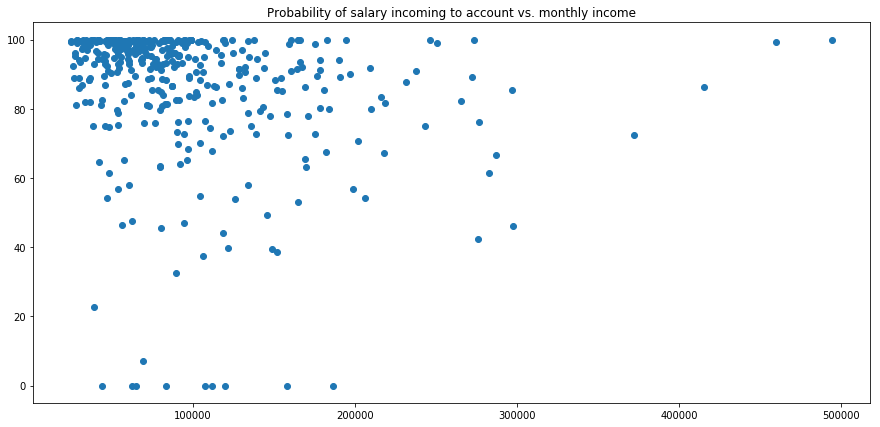

In [34]:
import numpy as np
import matplotlib.pyplot as plt

class Graph_plotting:
	
	def __init__(self, loaded):
		self.payments = loaded.payments
		self.keyset = loaded.keyset
		self.connections = loaded.payments_list
		
	def monthly_salary_perc(self):
		percentages = []
		sum_salary = []
		for k, v in self.connections.items():
			if len(v.salaries) >= 3:
				percentages.append([v.salary_perc, sum(np.array(v.salaries)[:,1])])
		percentages = np.array(sorted(percentages, key = lambda percentages:percentages[1]))
		plt.figure(figsize=(15,7))
		plt.plot(percentages[:,1],percentages[:,0], 'o')
		plt.title('Probability of salary incoming to account vs. monthly income')
		plt.show()
		plt.close()
        
gg = Graph_plotting(l)
gg.monthly_salary_perc()

#### 8.2. Výška platby vs. pravdepodobnosť, že na účet prichádza mzda

Graf vyjadruje pravdepodobnosť, že pre príchodzia platba je mzdou. Graf pracuje s platbami už vyfiltrovanými ako možné mzdy. 

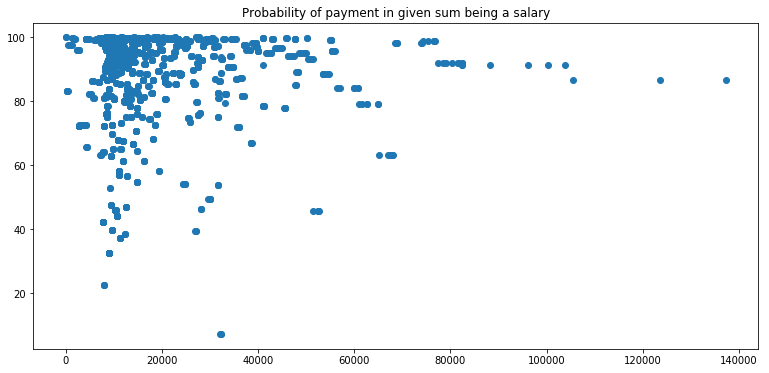

In [35]:
import numpy as np
import matplotlib.pyplot as plt

class Graph_plotting:
	
	def __init__(self, loaded):
		self.payments = loaded.payments
		self.keyset = loaded.keyset
		self.connections = loaded.payments_list
		
	def height_payment_salary_perc(self):
		all_amounts = set()
		percentages = []
		for k, v in self.connections.items():
			for p in v.amounts:
				if p < 160000 and v.salary_perc > 0:
					if p not in all_amounts:
						percentages.append(v.salary_perc)
					all_amounts.add(p)
		all_amounts_sorted = sorted(all_amounts)
		plt.figure(figsize=(13,6))
		plt.plot(all_amounts_sorted, percentages, 'o')
		plt.title('Probability of payment in given sum being a salary')
		plt.show()
		plt.close()
        
gg = Graph_plotting(l)
gg.height_payment_salary_perc()

### 8.3 Percentuálne rozdelenie výšky platieb

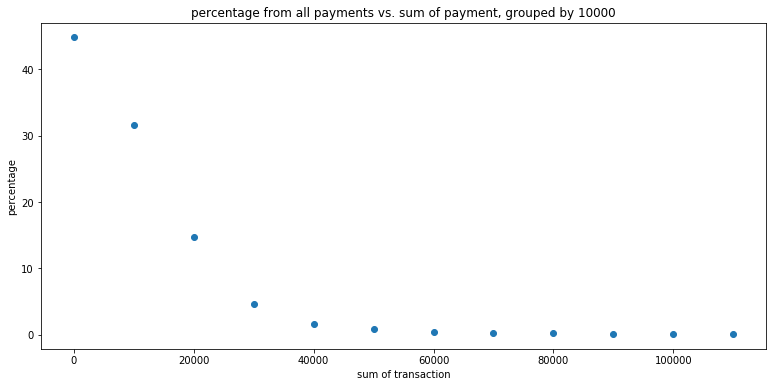

In [25]:
import numpy as np
import matplotlib.pyplot as plt

class Graph_plotting:
	
	def __init__(self, loaded):
		self.payments = loaded.payments
		self.keyset = loaded.keyset
		self.connections = loaded.payments_list
	def payment_grouped_issalary(self):
		cat_range = 10000
		max_r = 120000
		amounts = range(0, max_r, cat_range)
		amounts_dict = {}
		for am in amounts:
			amounts_dict[am] = 0
		for k, v in self.connections.items():
			for am in v.amounts:
				category = round(am / cat_range)*cat_range
				if category < max_r:
					amounts_dict[category] += 1
		for k,v in amounts_dict.items():
			amounts_dict[k] = (v / 427632)*100	#size of data, TODO: pass from loader file
		plt.figure(figsize=(13,6))
		plt.title('percentage from all payments vs. sum of payment, grouped by 10000')
		plt.xlabel('sum of transaction')
		plt.ylabel('percentage')
		plt.plot(list(amounts_dict.keys()), list(amounts_dict.values()), 'o')
		plt.show()
		plt.close()

gg = Graph_plotting(l)
gg.payment_grouped_issalary()

### 8.4. Pravdepodobnosť, že platba je mzdou vs. výška platby

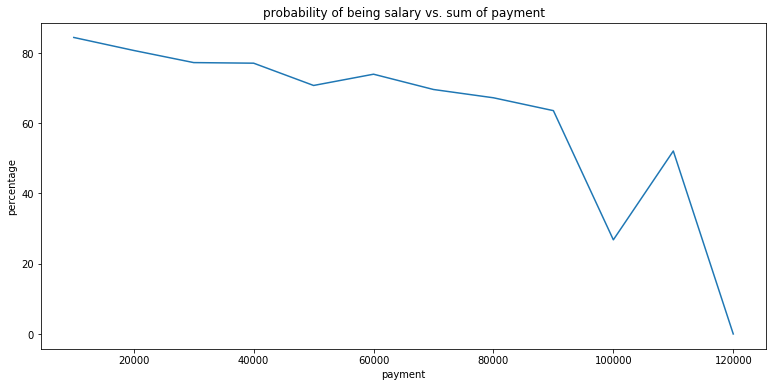

In [24]:
class Graph_plotting:
	
	def __init__(self, loaded):
		self.payments = loaded.payments
		self.keyset = loaded.keyset
		self.connections = loaded.payments_list
		
	def grouped_payment_perc_issalary(self):
		cat_range = 10000
		max_r = 120000
		percentage = {}
		perc2 = dict()
		for k, v in self.connections.items():
			if len(v.salaries) > 0:
				num_of_salaries = len(np.array(v.salaries)[:,1])
				for salary in np.array(v.salaries)[:,1]:
					category = round(salary / cat_range)*cat_range
					if category not in percentage.keys():
						percentage[category] = 0
						perc2[category] = 0
					if category < max_r:
						percentage[category] += v.salary_perc
						perc2[category] +=1
		for cat in range(10000, max_r, cat_range):
			if perc2[category] != 0:
				percentage[cat] = percentage[cat] / perc2[cat]
		to_plot = np.array(sorted(list(percentage.items())))
		plt.figure(figsize=(13,6))
		plt.title('probability of being salary vs. sum of payment')
		plt.ylabel('percentage')
		plt.xlabel('payment')
		plt.plot(to_plot[:,0], to_plot[:,1])
		plt.show()
		plt.close()
        
gg = Graph_plotting(l)
gg.grouped_payment_perc_issalary()

#### 9. Záver

Klasifikovali sme, pri ktorých platbách sa s akou pravdepodobnosťou jedná o mzdu. Predostreli sme metódu klasterizácie na identifikáciu 2 skupín transakcií medzi 2 účtami. Stratili sme dodatočnú informáciu o reťazcoch platieb nepoužitím grafovej štruktúry, no pre príjmy fyzických osôb to nepovažujeme za kritický problém. Naše percentuálne vyhodnotenie pravdepodobnosti, či je platba mzdou považujeme za približne správne aj kvôli poslednému grafu.
Vysoké percento pravdepodobnosti, že sa jedná o mzdu dostávame pri sumách, ktoré reálne môžu byť mzdou. Naše riešenie vykazuje možnú chybovosť pri nízkych hodnotách miezd, v okolí 15 000kč. Peak v okolí 110 000kč je buď zlá kategorizácia z našej strany alebo chyba simulácie.
Možné pokračovanie v riešení sme rozvinuli v kapitole 3.